# Mod6L5 Data Challenge — Interpreting SLR Output (Dec 2023 NYC Taxi)


**Format:** We Do (Instructor prompts) → You Do (Student work) → We Share (reflection)


**Goal:** Choose **one** dependent variable (**Y**) from the taxi dataset and build **three** simple linear regressions (each with a different single **X**) on **Dec 2023** rides. For each model, interpret the **coefficient**, **intercept**, **p‑value**, and **R‑squared** in plain business language. Then decide which model is “better” *for decision‑making* and why.


> **Reminder:** No train/test split or advanced metrics today. We focus on reading `.summary()` and communicating results.

## Instructor Section (10 mins)

**Follow these steps/considerations as you work**


1) **Pick a useful Y.** Which outcome would someone actually act on?  Who is the stakeholder for your Y?

*Avoid constructing Y that bakes in your X (e.g., avoid using `fare_amount` as X when Y = `total_amount` which already includes fare).*


2) **Choose three X’s** you can know at decision time, and that plausibly relate to Y. 

*You may engineer a feature to use in the model if you like*

*Note:  SLR needs numeric only inputs so variables like `PULocationID` can't be used (categorical → not for SLR today unless you transform; stick to numeric X for this exercise)*


3) **Interpretation lenses:**
- **Units:** Always state slope in units (e.g., “per mile”, “per minute”).
- **p‑value:** Does evidence suggest the slope ≠ 0?
- **R²:** How much of Y’s variation is captured by this X? Does that help the decision?
- **Intercept:** Is X=0 meaningful? If not, say it’s a math anchor.
- **Plausibility:** Does the direction/size make sense (e.g., longer trip → higher fare)?


4) **Better ≠ only higher R².** Weigh **interpretability**, **actionability**, and **evidence** (p‑value, CI) alongside R².

## YOU DO (40 mins)

### Step 1: Read in the Data & Choose your **Y** (dependent variable)

Pick one from the 2023_Yellow_Taxi_Trip_Data_20251015 csv file  

**Ro: Perchance, Tip amt**

### Step 2: Propose three candidate **X** predictors (numeric)

Pick three different X columns that are **numeric** and **known at decision time**.

**Ro:**

- passenger_count
- pickup time
- payment_type

### Step 3: Fit three one‑variable models with the SAME Y and different Xs

In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [44]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv'

df = pd.read_csv(path, low_memory=False)

In [45]:
df['passenger_count'].unique()

array([ 2.,  3.,  1.,  6.,  0., nan,  5.,  4.,  8.,  9.,  7.])

In [46]:
# converting tip_amount to float
df['tip_amount'] = pd.to_numeric(df['tip_amount'].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True), errors='coerce')

# converting passenger count
df['passenger_count'] = pd.to_numeric(df['passenger_count'].astype(str).str.strip().replace(to_replace='nan', value=0, regex=True), errors='coerce')
df['passenger_count'] = df['passenger_count'].astype(int)

# pickup hour
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

df.dtypes

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_23252/2656231753.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])


VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime            object
passenger_count                   int64
trip_distance                    object
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                      object
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                     object
congestion_surcharge            float64
airport_fee                     float64
pickup_hour                       int32
dtype: object

In [47]:
df['payment_type'].value_counts()

payment_type
1    2524107
2     535356
0     177380
4      52224
3      21840
Name: count, dtype: int64

In [48]:
# filtering tip_amount
df = df[(df['tip_amount'] >= 0) & df['tip_amount']< 1000]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour
0,2,2023-12-01 16:11:39,12/01/2023 04:19:13 PM,2,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3.00,0.00,1.0,17.4,2.5,0.00,16
1,1,2023-12-01 16:11:39,12/01/2023 04:20:41 PM,3,1.1,1.0,N,236,263,2,10,5.0,0.5,0.00,0.00,1.0,16.5,2.5,0.00,16
2,2,2023-12-01 16:11:39,12/01/2023 04:20:38 PM,1,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0.00,0.00,-1.0,-17.2,-2.5,0.00,16
3,2,2023-12-01 16:11:39,12/01/2023 04:20:38 PM,1,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0.00,0.00,1.0,17.2,2.5,0.00,16
4,1,2023-12-01 16:11:39,12/01/2023 04:34:39 PM,2,3,1.0,N,164,211,1,21.9,5.0,0.5,3.00,0.00,1.0,31.4,2.5,0.00,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3310902,2,2024-01-01 00:01:58,01/01/2024 12:10:04 AM,3,1.7,1.0,N,234,144,1,10.7,1.0,0.5,2.36,0.00,1.0,18.06,2.5,0.00,0
3310903,2,2024-01-03 10:00:04,01/03/2024 11:08:22 AM,1,21.6,1.0,N,132,136,1,82.1,0.0,0.5,18.46,6.94,1.0,110.75,0.0,1.75,10
3310904,2,2024-01-03 17:00:52,01/03/2024 05:01:05 PM,2,0,5.0,N,265,265,1,120,0.0,0.0,0.00,0.00,1.0,121,0.0,0.00,17
3310905,2,2024-01-03 18:43:26,01/03/2024 06:43:29 PM,2,0.01,5.0,N,95,95,1,86.69,0.0,0.0,17.54,0.00,1.0,105.23,0.0,0.00,18


In [49]:
# Model 1: passenger_count
X1 = sm.add_constant(df[['passenger_count']]) #add intercept yourself for statsmodels
y1 = df['tip_amount']
model = sm.OLS(y1, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6949.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:14:37   Log-Likelihood:            -9.8314e+06
No. Observations:             3310907   AIC:                         1.966e+07
Df Residuals:                 3310905   BIC:                         1.966e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.2077      0.004    714.280      0.000       3.199       3.217
passenger_count     0.2292      0.003     83.360      0.000       0.224       0.235
================================================================================
Omnibus:                 16506373.102   Durbin-Watson:                     1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   4731827832217859.000
Skew:                         212.079   Prob(JB):                           0.00
Kurtosis:                  185204.909   Cond. No.                           3.62
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_23252/2963284123.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x=df['passenger_count'], y=df['tip_amount'], color='red', ci=None)


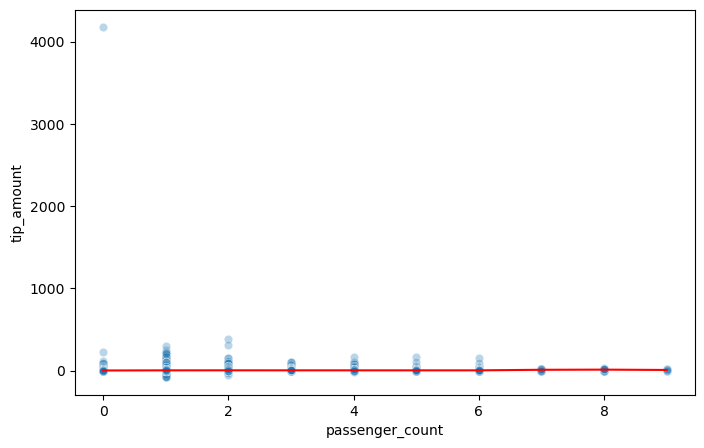

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df['passenger_count'], y=df['tip_amount'], alpha=0.3)
sns.lineplot(data=df, x=df['passenger_count'], y=df['tip_amount'], color='red', ci=None)
#plt.ylim((0,50))
plt.show()

<div align='center'>

### **Notes**

P-value tells us that there is a statistically significant effect, but the R-squared tells us that the effect size is not that big.

</div>

### Step 4: Visual check for the “best” model candidate

Pick the model you currently prefer (based on business sense + evidence).
- Create a scatter of X vs. Y with the fitted line.

### Step 5: Interpret Each Model (write in plain English)
Fill the three blocks below. Use **units** and **percentage points (pp)** where relevant.

- **Slope (β₁):** “For each +1 unit of X, Y changes by …”
- **Intercept (β₀):** meaningful or just a math anchor? Explain.
- **p‑value:** is there evidence the slope ≠ 0?
- **R²:** how much variation does this X explain?
- **Judgment:** is the effect size **practically** meaningful (tie to business)?

### Model A — Y = {{YOUR_Y}} ~ X1 = {{YOUR_X1}}
- Slope (β₁): …
- Intercept (β₀): …
- p‑value (slope): …
- 95% CI for slope: …
- R²: …
- Business readout (units): …
- One limitation: …

### Model B — Y = {{YOUR_Y}} ~ X2 = {{YOUR_X2}}
- Slope (β₁): …
- Intercept (β₀): …
- p‑value (slope): …
- 95% CI for slope: …
- R²: …
- Business readout (units): …
- One limitation: …

### Model C — Y = {{YOUR_Y}} ~ X3 = {{YOUR_X3}}
- Slope (β₁): …
- Intercept (β₀): …
- p‑value (slope): …
- 95% CI for slope: …
- R²: …
- Business readout (units): …
- One limitation: …

## We Share (10 mins) — Reflection & Decision (write 1-2 short paragraphs)

1) **Which model is “better” for a stakeholder decision and why?**
- Weigh **evidence** (p‑value, CI), **explanatory power** (R²), **interpretability**, and **business impact** (units, MDE if relevant).
2) **What would you do next week to strengthen trust in this model?**
- (Preview) time‑based validation, hold‑out testing, segment checks, adding more plausible X’s, checking assumptions.